In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import numpy as np
import numpy.random as rnd
import pandas as pd
import scipy.stats as stats
from scipy.special import logsumexp, digamma, gammaln
import seaborn as sns
from typing import *
from tqdm import tqdm

# 各分布のハイパーパラメーターなどを保持するクラスの定義ファイル
from dists_and_models import Gamma, Poisson, BayesPoiMixModel, PoiMixModel


plt.style.use("ggplot")
sns.set_context("poster")

ユーティリティ関数を定義する。

In [2]:
def calc_ELBO(X, prior: BayesPoiMixModel, posterior: BayesPoiMixModel): # X: Mat{float}
    """ ELBOを計算する。付録A.4を参照のこと。
    Args:
        X: 
        prior: 
        posterior: 
    """
    ln_expt_S = update_S(posterior, X)
    expt_S = np.exp(ln_expt_S)
    K, N = expt_S.shape
    D = X.shape[0]

    # A.4の表式どおりに計算する。
    expt_ln_lambda = np.zeros((D, K))
    expt_lambda = np.zeros((D, K))
    expt_ln_lkh = 0
    for k in range(K):
        expt_ln_lambda[:,k] = digamma(posterior.gamma[k].a) - np.log(posterior.gamma[k].b)
        expt_lambda[:,k] = posterior.gamma[k].a / posterior.gamma[k].b
        for n in range(N):
            expt_ln_lkh += expt_S[k,n] * (
                X[:, n].T * expt_ln_lambda[:,k] 
                    - sum(expt_lambda[:,k]) - sum(gammaln(X[:,n]+1))
            )[0]

    expt_ln_pS = sum(sum(expt_S.T * (digamma(posterior.alpha) - digamma(sum(posterior.alpha)))))
    
    expt_ln_qS = sum(sum(expt_S * ln_expt_S))
    # KLダイバージェンスを計算する。
    # KL[q(lambda)||p(lambda)]
    KL_lambda = 0
    for k in range(K):
        KL_lambda += (
            sum(posterior.gamma[k].a)*np.log(posterior.gamma[k].b) 
                - sum(prior.gamma[k].a)*np.log(prior.gamma[k].b)
                - sum(gammaln(posterior.gamma[k].a)) + sum(gammaln(prior.gamma[k].a))
                + (posterior.gamma[k].a - prior.gamma[k].a).T * expt_ln_lambda[:,k][0]
                + (prior.gamma[k].b - posterior.gamma[k].b) * sum(expt_lambda[:,k])
        )[0]
        
    # KL[q(pi)||p(pi)]
    KL_pi = (
        gammaln(sum(posterior.alpha)) 
            - gammaln(sum(prior.alpha))
            - sum(gammaln(posterior.alpha)) + sum(gammaln(prior.alpha))
            + (posterior.alpha - prior.alpha).T 
        * (digamma(posterior.alpha) - digamma(sum(posterior.alpha)))
    )[0]
    return expt_ln_lkh + expt_ln_pS - expt_ln_qS - (KL_lambda + KL_pi)


def add_stats(bpmm: BayesPoiMixModel, X, S):  # X: Matrix{Float64}, S: Matrix{Float64}
    D = bpmm.num_dim
    K = bpmm.num_cluster
    sum_S = S.sum(axis=1)
    alpha = [bpmm.alpha[k] + sum_S[k] for k in range(K)]
    gamDists = [] # Vector{Gam}()
    XS = X @ S.T;
    for k in range(K):
        a = np.ones(D)
        for d in range(D):
            a[d] = a[d]*float(bpmm.gamma[k].a[d] + XS[d,k])
        b = bpmm.gamma[k].b + sum_S[k]
        gamDists.append(Gamma(a=a, b=b))
    return BayesPoiMixModel(num_dim=D, num_cluster=K, alpha=alpha, gamma=gamDists)


def remove_stats(bpmm: BayesPoiMixModel, X, S): # X: Matrix{Float64}, S: Matrix{Float64}
    return add_stats(bpmm, X, -S)

In [3]:
# Sample a PMM given hyperparameters.
def sample_PMM(bpmm: BayesPoiMixModel) -> PoiMixModel:
    pois = []
    for c in bpmm.gamma:
        lambda_ = np.zeros(bpmm.num_dim)
        for d in range(bpmm.num_dim):
            lambda_[d] = rnd.gamma(shape=c.a[d], scale=1.0/c.b)
        pois.append(Poisson(lambda_ = lambda_))
    return PoiMixModel(
        num_dim = bpmm.num_dim, 
        num_cluster = bpmm.num_cluster,
        phi = rnd.dirichlet(bpmm.alpha),
        poisson=pois
    )


# Sample data from a specific PMM model.
def sample_data(pmm: PoiMixModel, N: int):
    x = np.zeros((pmm.num_dim, N)) #np.matrix(np.zeros(pmm.D, N))
    s = categorical_sample(pmm.phi, N)
    for n in range(N):
        k = np.argmax(s[:, n])
        for d in range(pmm.num_dim):
            x[d, n] = rnd.poisson(pmm.poisson[k].lambda_[d])
    return x, s

#categorical_sample(p::Vector{Float64}) = categorical_sample(p, 1)[:,1]

def categorical_sample(p: List[float], N: int = 1):
    K = len(p)
    S = np.zeros((K, N)) # np.matrix(np.zeros(K, N))
    # numpy.randomにはわかりやすくcategorical sampleを行う関数がない。
    # ググったところ、numpy.random.Generator.choice()がカテゴリ分布になっているらしい。
    # http://bois.caltech.edu/distribution_explorer/discrete/categorical.html
    S_tmp = rnd.default_rng().choice(len(p), N, p=p)
    for k in range(K):
        #S[S[k, S_tmp == k]] = 1
        #S[k,find(S_tmp==k)] = 1
        S[k, S_tmp == k] = 1
    return S if N != 1 else S[:, 0]


def init_S(x, bpmm: BayesPoiMixModel): # X: Matrix{float}
    s = categorical_sample(np.ones(bpmm.num_cluster)/bpmm.num_cluster, x.shape[1])    
    return s

ギブスサンプリングを実装する。

In [4]:
# used for Gibbs Sampling
def sample_S_GS(pmm: PoiMixModel, X):  # X: Matrix{Float64}
    D, N = X.shape
    K = pmm.num_cluster
    S = np.zeros((K, N))
    tmp = [-sum(pmm.poisson[k].lambda_) + np.log(pmm.phi[k]) for k in range(K)]
    ln_lambda_X = [X.T*np.log(pmm.poisson[k].lambda_) for k in range(K)]
    for n in range(N):
        tmp_ln_phi = [(tmp[k] + ln_lambda_X[k][n]) for k in range(K)]
        # 知らなかったのでメモ：詳細は https://qiita.com/BigSea/items/1949b3ceefcec4fc32ea
        # logsumexp()ってなんだよlog(sum(exp(.)))でええやん、、、？みたいな気持ちになるが、
        # log(sum(exp(.)))した結果はアンダー・オーバーフローしない範囲に収まっていても、
        # exp(.)の時点でアンダー・オーバーフローしたら全てがおじゃんなので、これを回避するための計算法
        # （面白い；実際書き下して回したらアンダーフローした、そりゃそうだ）
        tmp_ln_phi = tmp_ln_phi - logsumexp(tmp_ln_phi)
        S[:,n] = categorical_sample(np.exp(tmp_ln_phi).T[0,:])
    return S


def conduct_Gibbs_sampling(x, s, prior: BayesPoiMixModel):  # X::Matrix{Float64}
    # sample parameters
    pmm = sample_PMM(prior)
    # sample latent variables
    s = sample_S_GS(pmm, x)
    # update current model
    posterior = add_stats(prior, x, s)
    return s, posterior, calc_ELBO(x, prior, posterior)

変分推論を実装する。

In [5]:
# Compute posterior distribution via variational inference.
def update_S(prior: BayesPoiMixModel, x):
    D, N = x.shape
    num_cluster = prior.num_cluster
    ln_expt_S = np.zeros((num_cluster, N))
    tmp = np.zeros(num_cluster)

    sum_digamma_tmp = digamma(sum(prior.alpha))
    for k in range(num_cluster):
        tmp[k] = - sum(prior.gamma[k].a) / prior.gamma[k].b
        tmp[k] += digamma(prior.alpha[k]) - sum_digamma_tmp
    ln_lambda_X = [x.T*(digamma(prior.gamma[k].a) - np.log(prior.gamma[k].b)) for k in range(num_cluster)]
    for n in range(N):
        tmp_ln_pi =  [tmp[k] + ln_lambda_X[k][n] for k in range(num_cluster)]
        ln_expt_S[:,n] = (tmp_ln_pi - logsumexp(tmp_ln_pi))[:, 0]
    return ln_expt_S


def conduct_variational_inference(x, s, prior: BayesPoiMixModel):  # X: Matrix{Float64}
    """ 変分推論により事後分布を推定する。
    """
    # E-step
    expt_S = np.exp(update_S(prior, x))
    # M-step
    posterior = add_stats(prior, x, expt_S)
    return expt_S, posterior, calc_ELBO(x, prior, posterior)

崩壊型ギブスサンプリングを実装する。

In [6]:
# used for Collapsed Gibbs Sampling
def calc_ln_NB(Xn, gam: Gamma): # Xn: Vector{Float64}
    return sum([
        float(gam.a[d]*np.log(gam.b)
            - gammaln(gam.a[d])
            + gammaln(Xn[d] + gam.a[d])
            - (Xn[d] + gam.a[d])*np.log(gam.b + 1)
        ) for d in range(Xn.shape[0])
    ])


def sample_Sn(Xn, bpmm: BayesPoiMixModel): # Xn: Vector{Float64}
    ln_tmp = [(calc_ln_NB(Xn, bpmm.gamma[k]) + np.log(bpmm.alpha[k])) for k in range(bpmm.num_cluster)]
    ln_tmp = ln_tmp -  logsumexp(ln_tmp)
    Sn = categorical_sample(np.exp(ln_tmp))
    return Sn


def sample_S_CGS(S, X, bpmm: BayesPoiMixModel):  # S: Matrix{Float64}, X: Matrix{Float64}
    D, N = X.shape
    K = S.shape[0]
    for n in rnd.permutation(N):
        bpmm = remove_stats(bpmm, X[:,[n]], S[:,[n]])  # remove
        S[:,n] = sample_Sn(X[:,n], bpmm)  # sample
        bpmm = add_stats(bpmm, X[:,[n]], S[:,[n]])  # insert
    return S, bpmm


def conduct_collapsed_Gibbs_sampling(x, s, prior: BayesPoiMixModel):  
    # directly sample S
    s, posterior = sample_S_CGS(s, x, prior)
    return s, posterior, calc_ELBO(x, prior, posterior)

指定されたアルゴリズムをstep-by-stepに実行していくwrapperを作っておく。

In [7]:
algorithms = {
    "GS": conduct_Gibbs_sampling, 
    "VI": conduct_variational_inference, 
    "CGS": conduct_collapsed_Gibbs_sampling,
}


def learn_step_by_step(x, s, prior: BayesPoiMixModel, algo: str):
    return algorithms[algo](x, s, prior)


class Cache:
    def __init__(self, s, prior):
        self.s = s
        self.prior = prior


def learn(x, s, prior: BayesPoiMixModel, iter_=1000):
    # 初期化
    s = init_S(x, prior)
    prior = add_stats(prior, x, s)
    
    # 各アルゴリズムの結果をキャッシュしておく変数を作る
    gs, vi, cgs = Cache(s, prior), Cache(s, prior), Cache(s, prior)
    path = {"GS": [], "VI": [], "CGS": []}
    for i in tqdm(range(iter_)):
        gs_s, gs_post, gs_v = learn_step_by_step(x, gs.s, gs.prior, "GS")
        vi_s, vi_post, vi_v = learn_step_by_step(x, vi.s, vi.prior, "VI")
        cgs_s, cgs_post, cgs_v = learn_step_by_step(x, cgs.s, cgs.prior, "CGS")
        # update（もっと綺麗な書き方がありそう…）
        gs, vi, cgs = Cache(gs_s, gs_post), Cache(vi_s, vi_post), Cache(cgs_s, cgs_post)
        # pathを記録しておく
        path["GS"].append(gs_v)
        path["VI"].append(vi_v)
        path["CGS"].append(cgs_v)
    return gs, vi, cgs, path

モデルを作って、クラスタリングを行うデータを見てみる。

(array([ 20.,  71., 168., 170., 120.,  96., 143., 130.,  66.,  16.]),
 array([263. , 279.2, 295.4, 311.6, 327.8, 344. , 360.2, 376.4, 392.6,
        408.8, 425. ]),
 <a list of 10 Patch objects>)

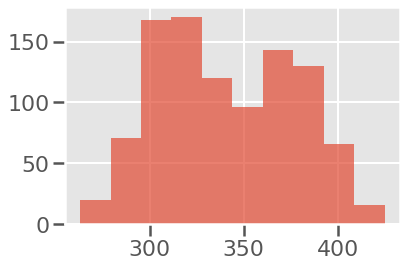

In [8]:
# モデルの構築
prior_ = BayesPoiMixModel(
    num_dim=1, 
    num_cluster=2, 
    alpha=100.0, 
    gamma=Gamma(a=1.0*np.ones(1), b=0.01)
)

pmm_ = sample_PMM(prior_)  # 真のモデルを作る
x_, s_ = sample_data(pmm_, 1000)  # データを作る
plt.hist(x_[0, :], alpha=.7)

ざっくりと2峰性の分布になっていることがわかる（何回か繰り返してください…）。このデータに対してクラスタリングを行ってみる。

In [9]:
# 上手く教科書どおりのが出ないときは、このデータを読み込む
source = pd.read_csv("data/poisson_mixture_model.csv")
x_, s_ = np.array([source.loc[:, "X"]]), np.array([source.loc[:, "S0"], source.loc[:, "S1"]])

In [10]:
# 何回か実験したところ、この条件ではiterationに1000もいらず、100で十分と言うことがわかった
results = learn(x_[0:100], s_[0:100], prior_, iter_=100)

100%|██████████| 100/100 [01:36<00:00,  1.03it/s]


In [11]:
path = pd.DataFrame(results[3])

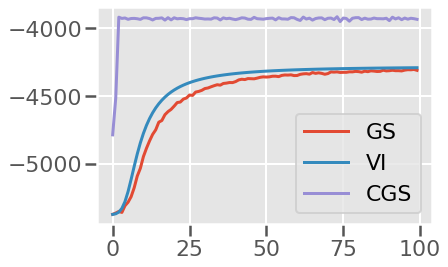

In [12]:
path.plot()

array([0., 0., 0., 0., 0., 0., 0., 0.])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

array([0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0.])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

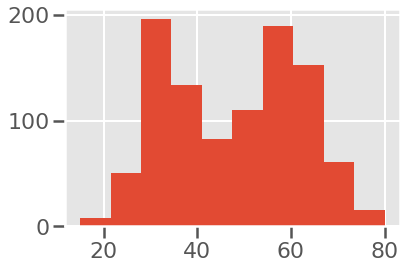

In [41]:
def draw(x, predicted_s):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    _, bins, patches = ax.hist(x[0])
    for i, patch in enumerate(patches):
        display(predicted_s[0][(x_[0] >= bins[i]) & (x_[0] <= bins[i+1])])

draw(x_, results[0].s)